# Simmetry product mask
The main goal of this notebook is to mask for the body.

In [1]:
from covidxpert import load_image, perspective_correction, blur_bbox
from covidxpert.utils import remove_artefacts, normalize_image, add_padding, trim_padding, inpaint
from covidxpert.blur_bbox.blur_bbox import strip_black, compute_median_threshold
from covidxpert.perspective_correction.get_corners import get_cardinal_corner_points
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple

In [2]:
def darken(image, clip:float=15, kernel:Tuple=(15,15)):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=kernel)
    image = clahe.apply(image)
    image = cv2.equalizeHist(image)
    return image

In [3]:
def simmetry_trim(image, x):
    min_side = min(image.shape[1] - x, x)
    return image[:, x-min_side: x+min_side]

def trim_flip(image, x):
    cut_image = simmetry_trim(image, x)
    flipped = np.flip(cut_image, axis=1)
    return cut_image, flipped

In [4]:
def simmetry_loss(image:np.ndarray, x:int):
    cut_image, flipped = trim_flip(image, x) 
    return np.mean((cut_image-flipped)**2)

In [5]:
def simmetry_axis(image:np.ndarray, n:int=1000)->int:
    best_x = image.shape[1]//2
    min_loss = simmetry_loss(image, best_x)
    side_padding = 0.45
    xs = set(np.random.randint(
        int(image.shape[1]*side_padding),
        int(image.shape[1]*(1-side_padding)),
        size=n
    ))
    for x in xs:
        loss = simmetry_loss(image, x)
        if loss < min_loss:
            best_x = x
            min_loss = loss

    return best_x

In [6]:
def remove_small_artefacts(image, factor:int):
    _, output, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]
    area = np.prod(image.shape)

    for i, size in enumerate(sizes):
        if size < area/factor:
            image[output == i+1]=0

    return image

In [7]:
def fill_in_small_artefacts(image, factor:int):
    inverted = image.max() - image
    _, output, stats, _ = cv2.connectedComponentsWithStats(inverted, connectivity=8)
    sizes = stats[1:, -1]
    area = np.prod(inverted.shape)

    for i, size in enumerate(sizes):
        if size < area/factor:
            image[output == i+1]=255

    return image

In [8]:
def get_black_border_regions(image, border_size:int=3):
    inverted = image.max() - image
    _, output, stats, _ = cv2.connectedComponentsWithStats(inverted, connectivity=8)
    sizes = stats[1:, -1]

    border_regions = np.zeros_like(image, dtype=bool)

    for i, size in enumerate(sizes):
        region = output == i+1
        x = region.any(axis=0)
        y = region.any(axis=1)
        if x[:border_size].any() or x[-border_size:].any() or y[:border_size].any() or y[-border_size:].any():
            border_regions |= region

    return border_regions

In [9]:
def _get_borders(image:np.ndarray, x:int)->np.ndarray:
    cut_image, flipped = trim_flip(image, x)

    cut_image_mask = cv2.threshold(cut_image, np.median(cut_image)/2, 255, cv2.THRESH_BINARY)[1]
    flipped_mask = cv2.threshold(flipped, np.median(flipped)/2, 255, cv2.THRESH_BINARY)[1]
    sum_reflected = normalize_image(cut_image.astype(float) + flipped.astype(float))
    sum_mask = cv2.threshold(sum_reflected, np.median(sum_reflected)/2, 255, cv2.THRESH_BINARY)[1]

    cut_image_borders = get_black_border_regions(cut_image_mask)
    flipped_borders = get_black_border_regions(flipped_mask)
    sum_borders = get_black_border_regions(sum_mask)

    borders = normalize_image(cut_image_borders | flipped_borders | sum_borders)
    borders = normalize_image(sum_borders)
    borders = cv2.dilate(borders, np.ones((15, 15)))
    borders = fill_in_small_artefacts(borders, 50)

    return borders

def get_borders(image:np.ndarray, x)->np.ndarray:
    wide_borders = _get_borders(darken(image), x)
    short_borders = _get_borders(image, x)
    borders = normalize_image(wide_borders+short_borders)
    borders = add_padding(trim_padding(borders, 30), 30, 255)
    borders = cv2.dilate(borders, np.ones((9, 9)))
    borders = cv2.medianBlur(borders, 15)
    borders = cv2.threshold(borders, np.median(borders), 255, cv2.THRESH_BINARY)[1]
    borders = fill_in_small_artefacts(borders, 50)
    return borders

In [10]:
def fill_lower_max(image:np.ndarray, lower_padding:int=50)->np.ndarray:
    half_image = np.zeros_like(image)
    half = half_image.shape[0]//2
    half_image[half:-lower_padding] = image[half:-lower_padding]
    argmax = np.argmax(half_image.mean(axis=1))
    half_image[argmax:] = half_image[argmax]
    image = image.copy()
    image[half_image>0] = 255
    return image

In [11]:
def get_default_mask(image:np.ndarray, borders:np.ndarray)->np.ndarray:
    """Apply default mask over given image.
    
    Parameters
    ----------------
    image:np.ndarray,
        The image over which to apply the mask.
    borders:np.ndarray
        The borders to use.

    Returns
    ----------------
    The mask obtained over the image.
    """
    mask = cv2.threshold(image, np.median(image), 255, cv2.THRESH_BINARY)[1]
    mask[borders>0] = 255
    width = mask.shape[1]
    mask[:, int(width*0.45):int(width*0.55)] = 255
    return mask

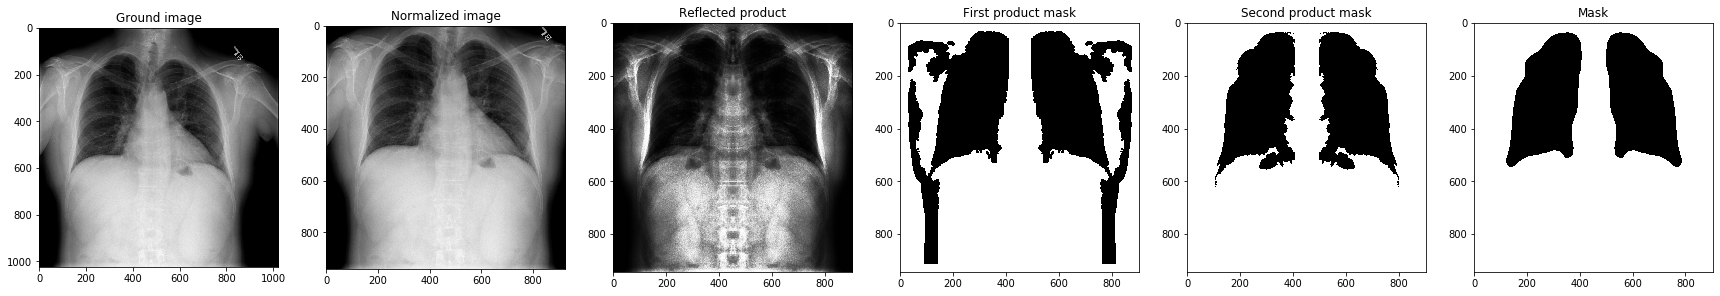

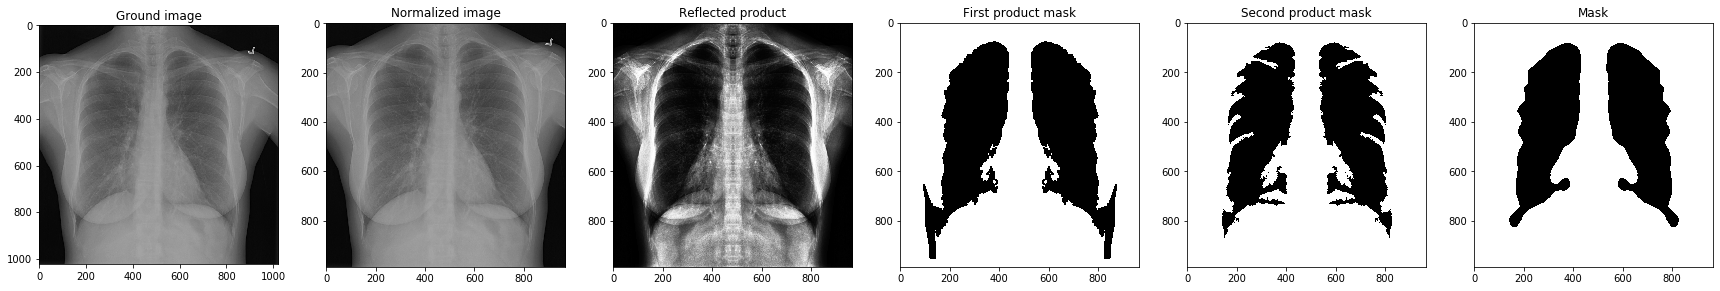

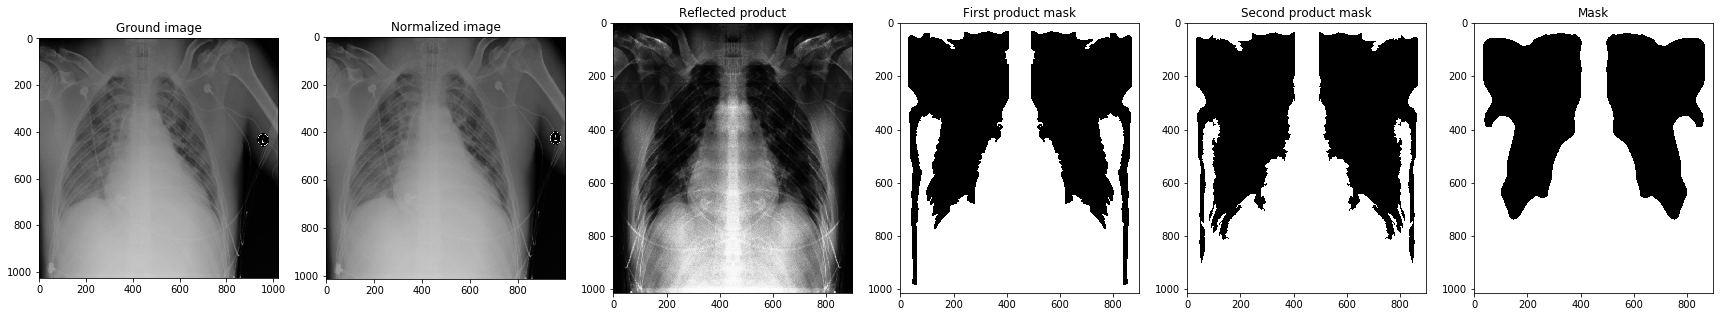

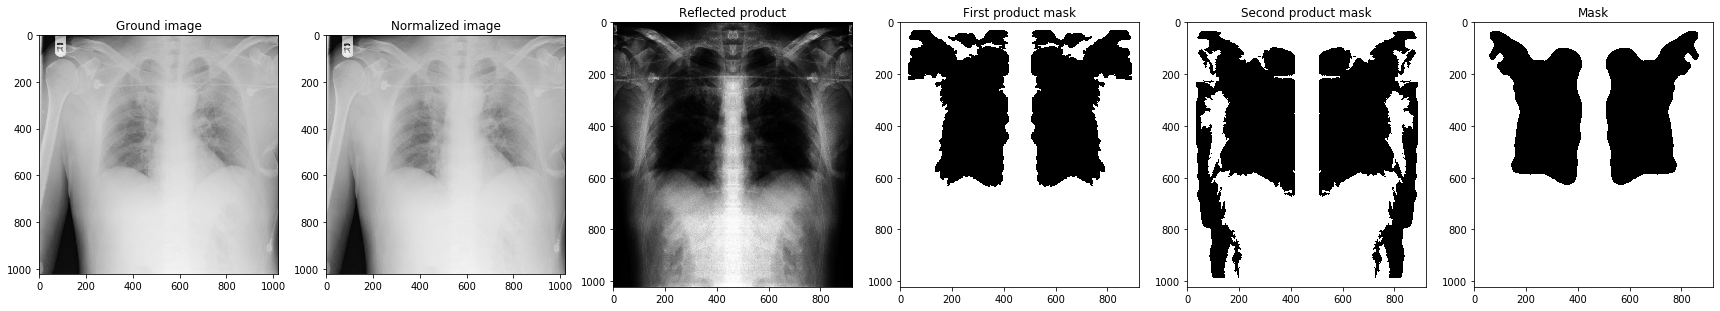

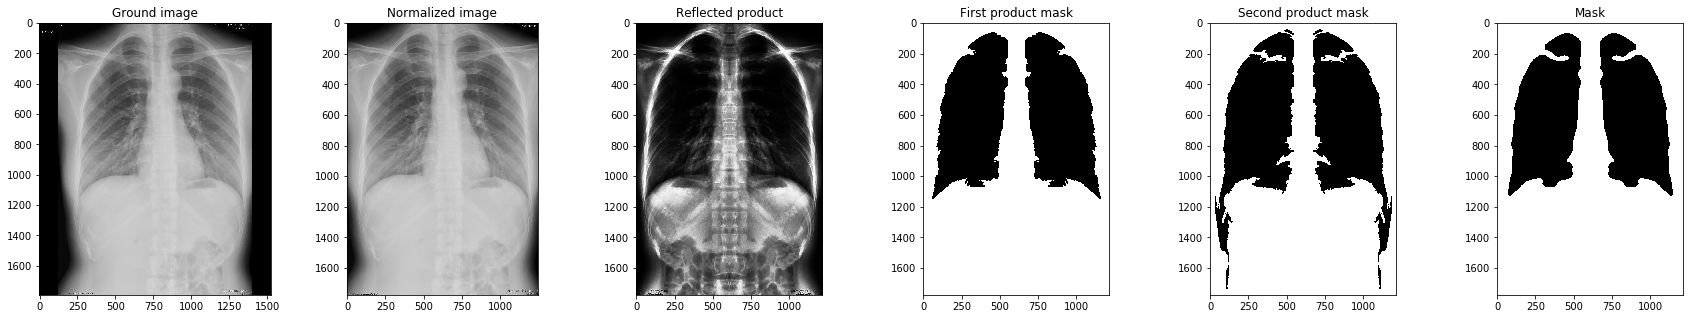

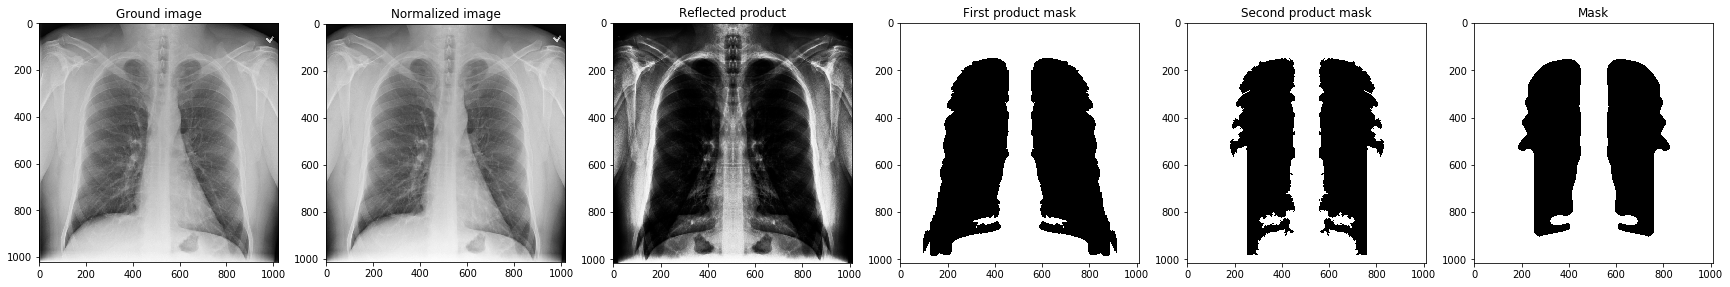

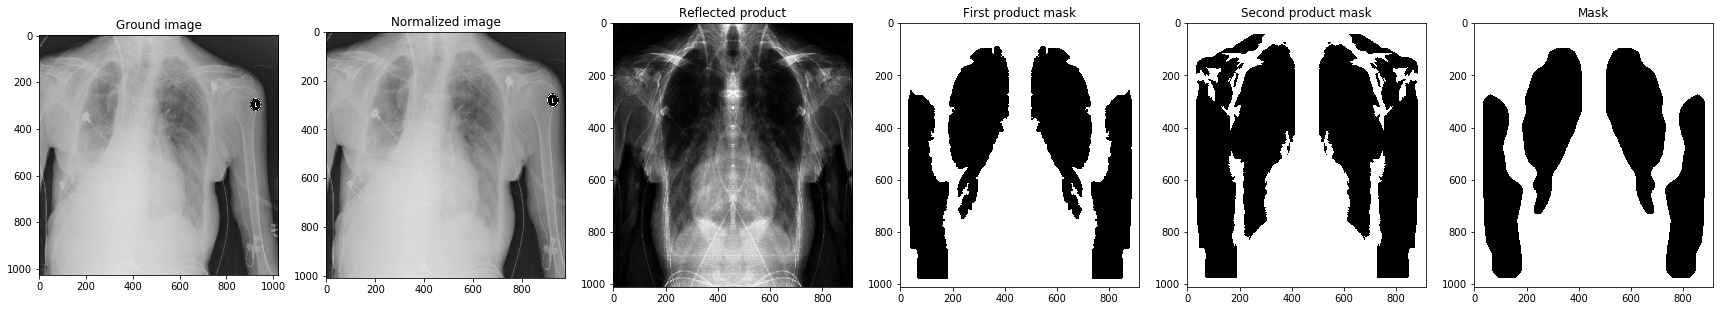

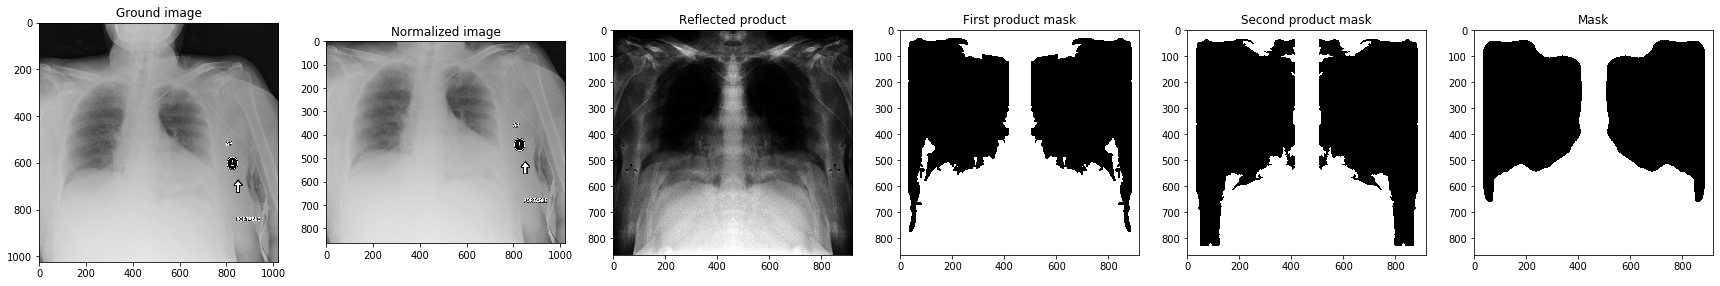

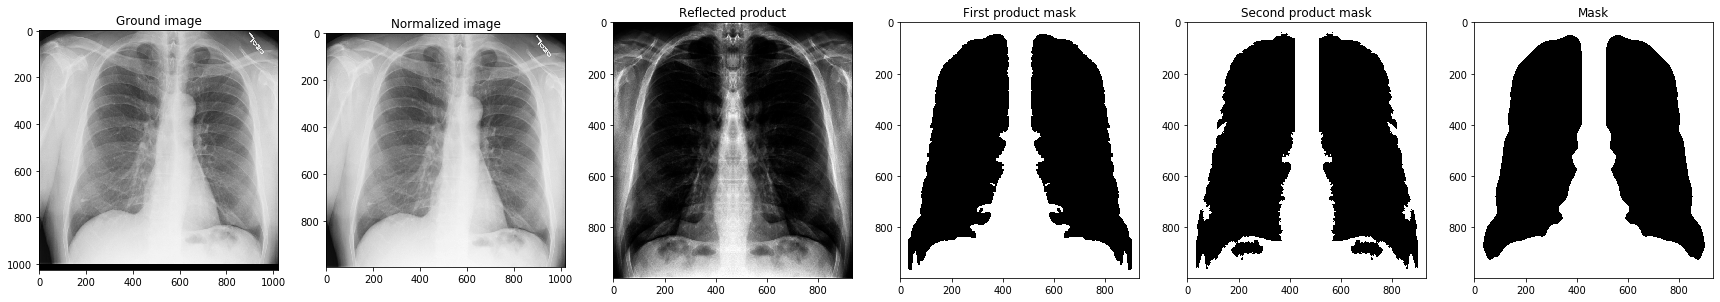

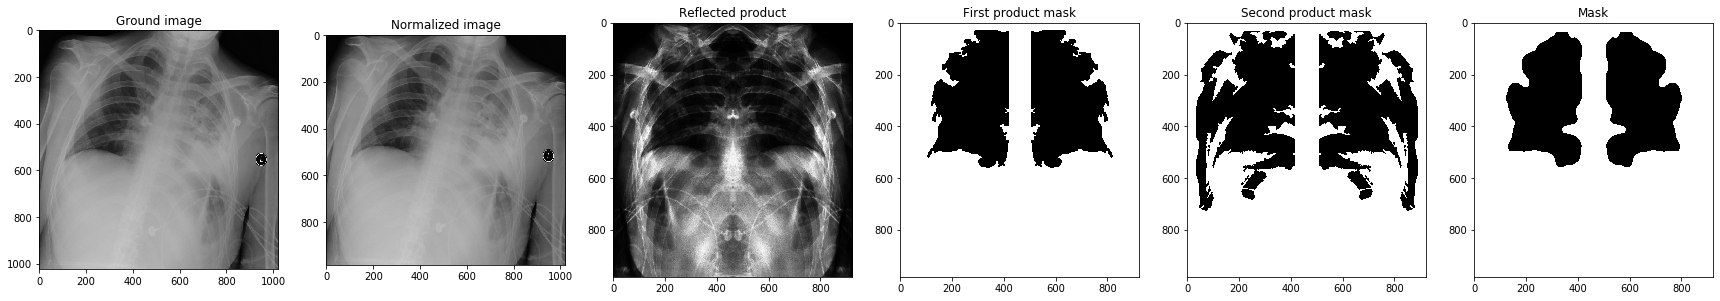

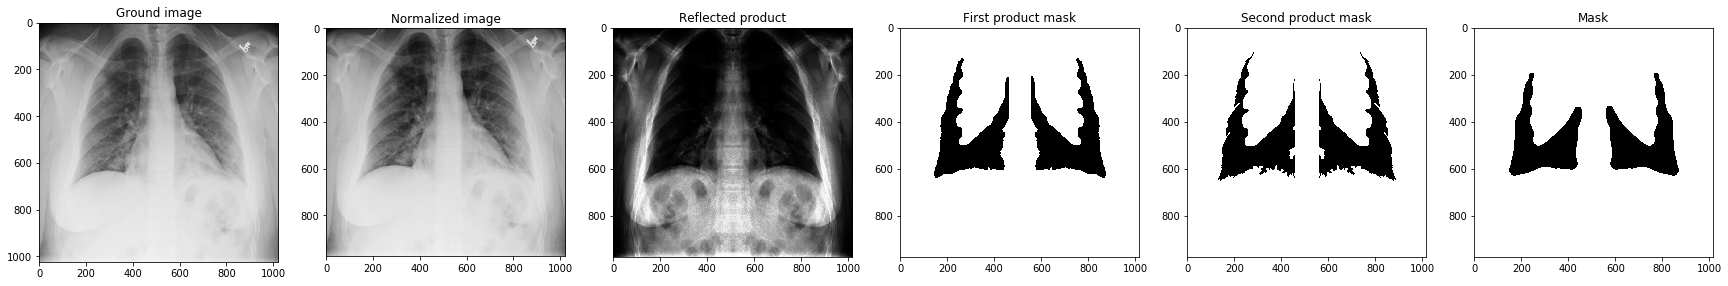

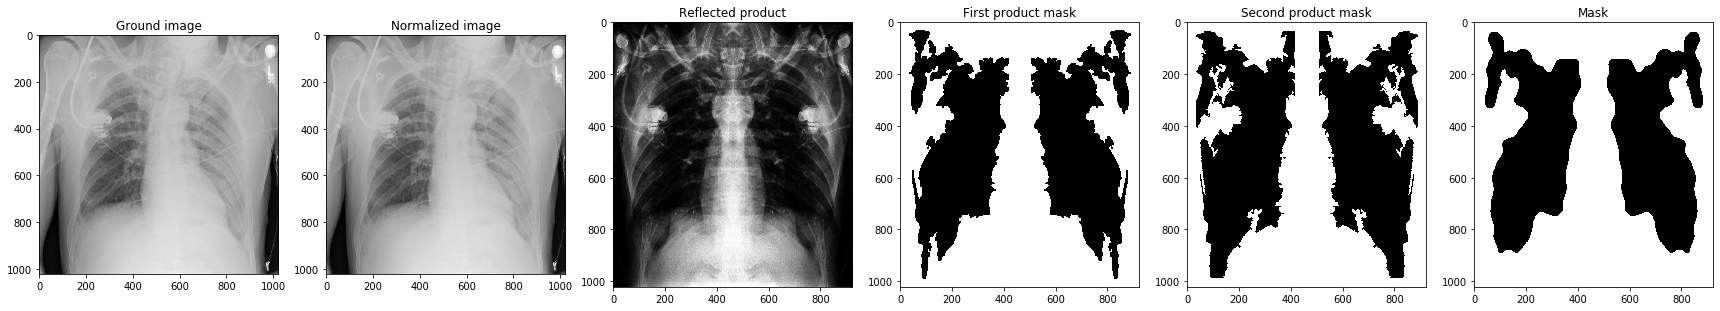

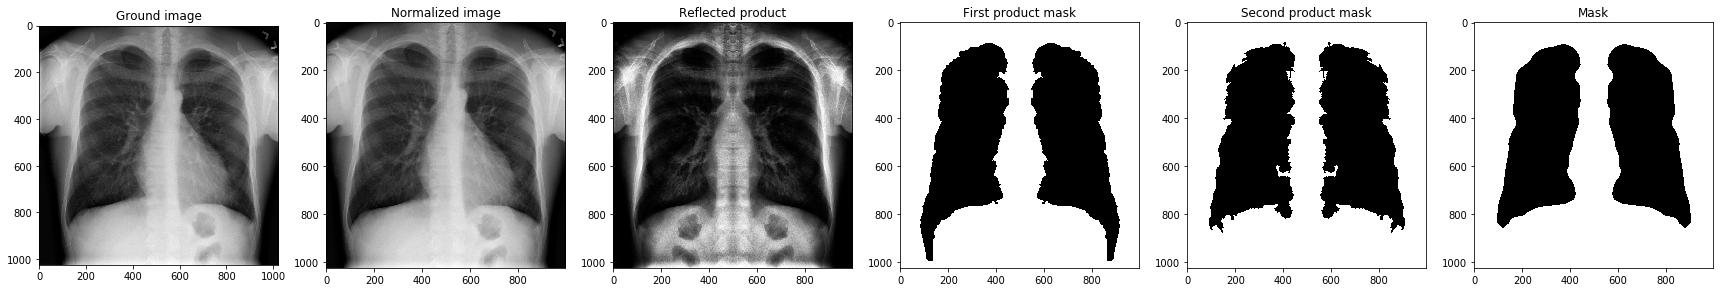

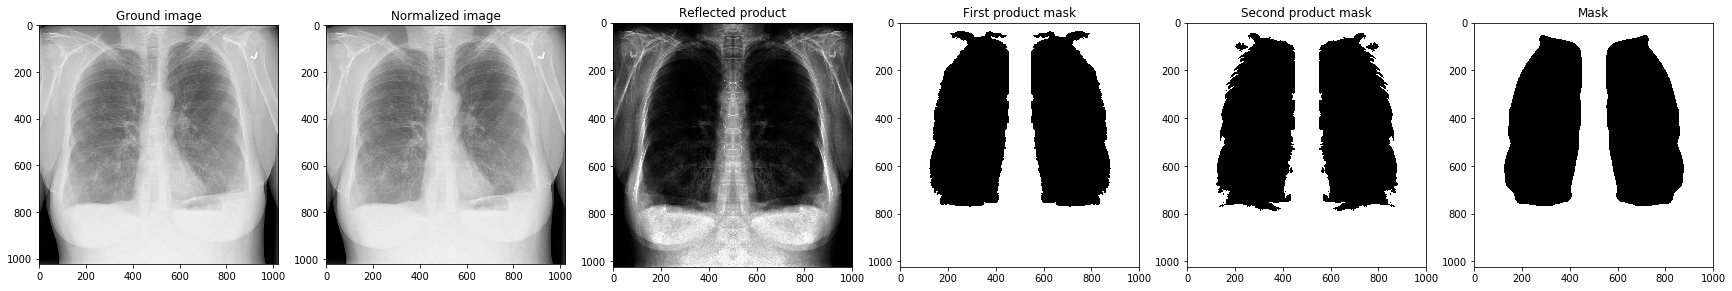

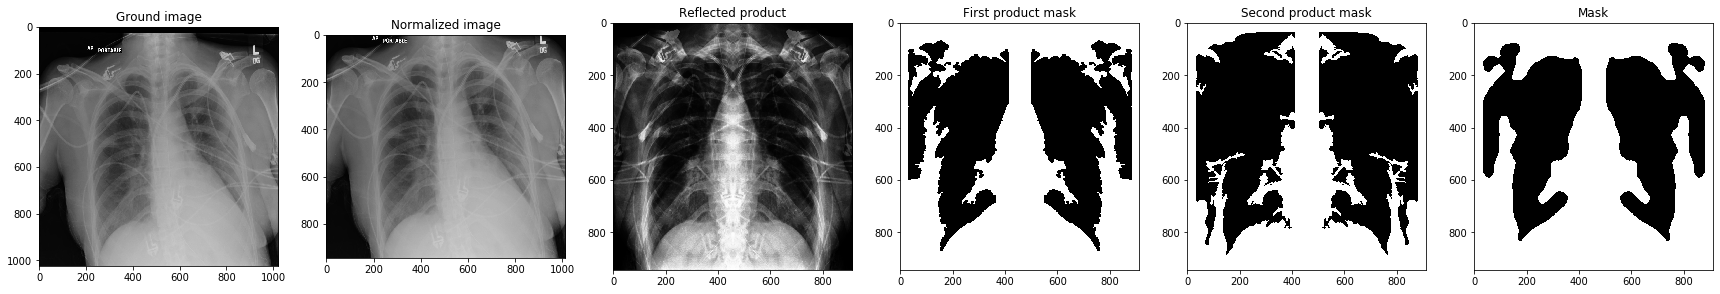

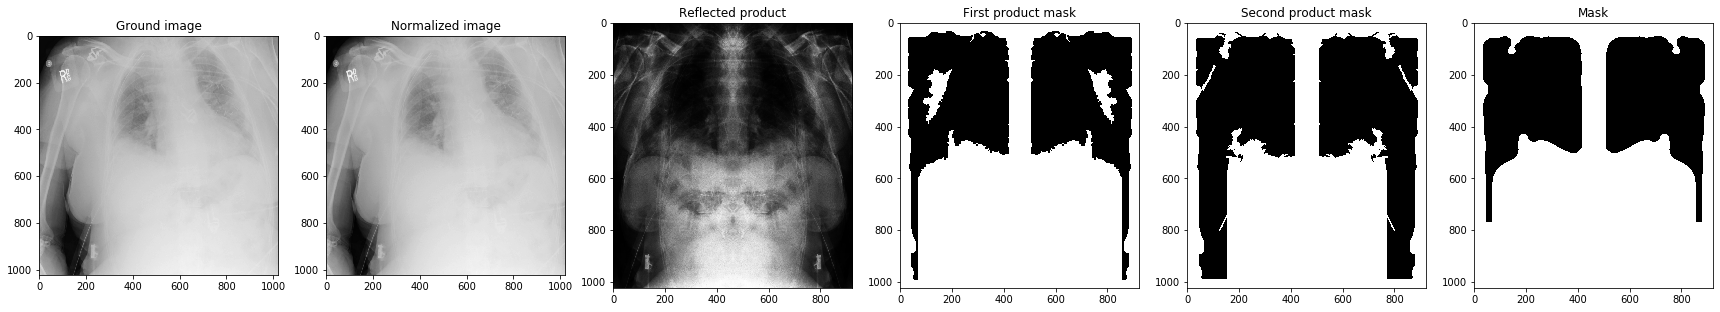

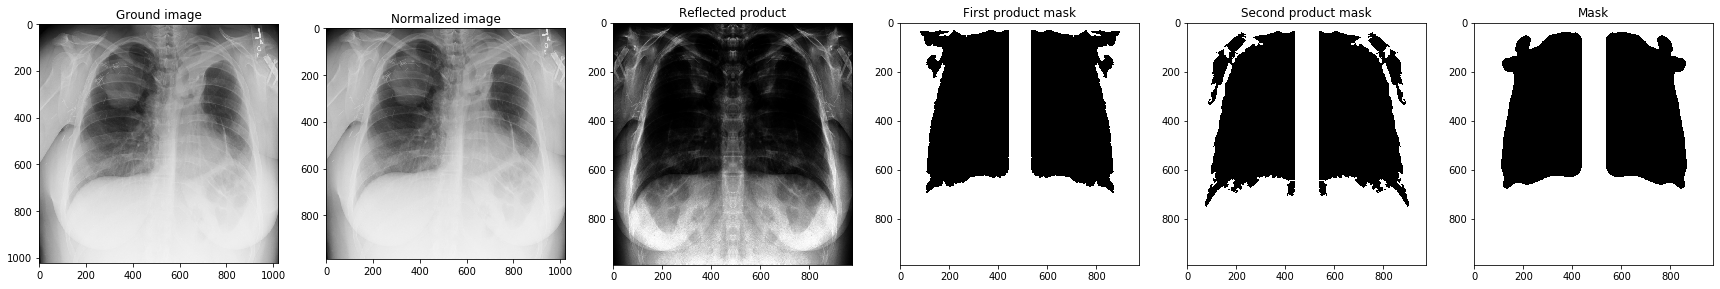

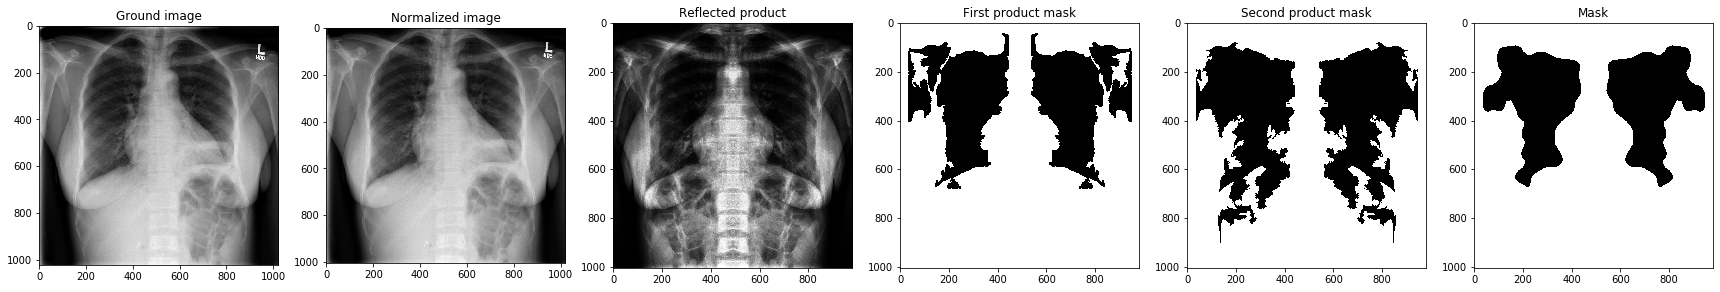

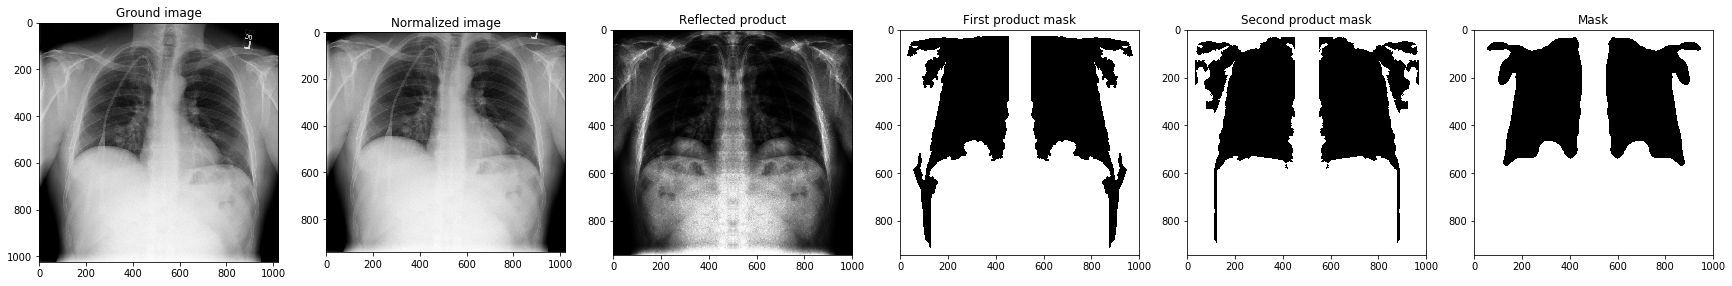

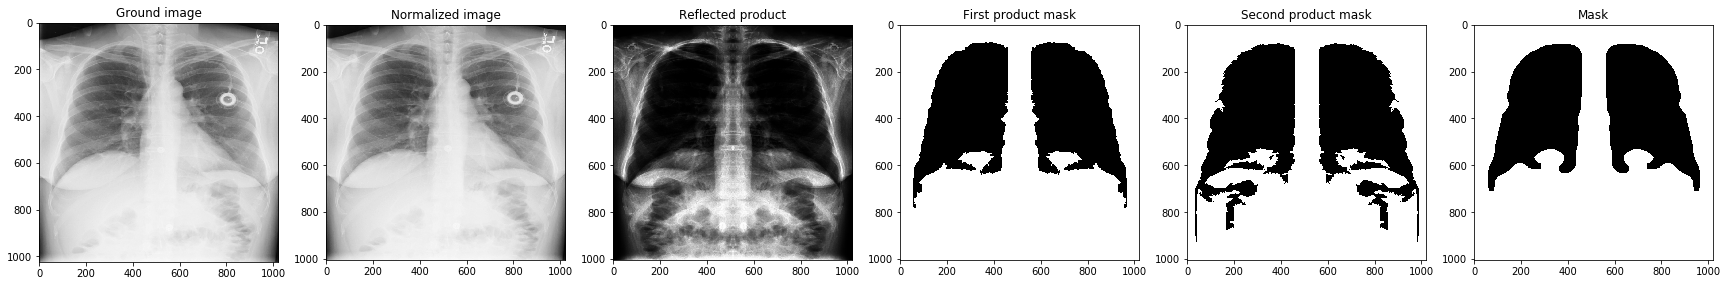

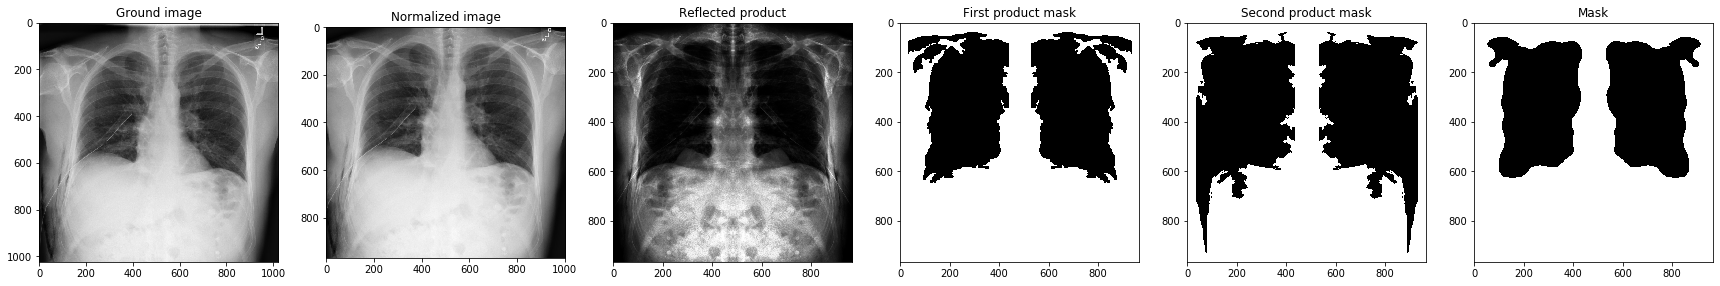

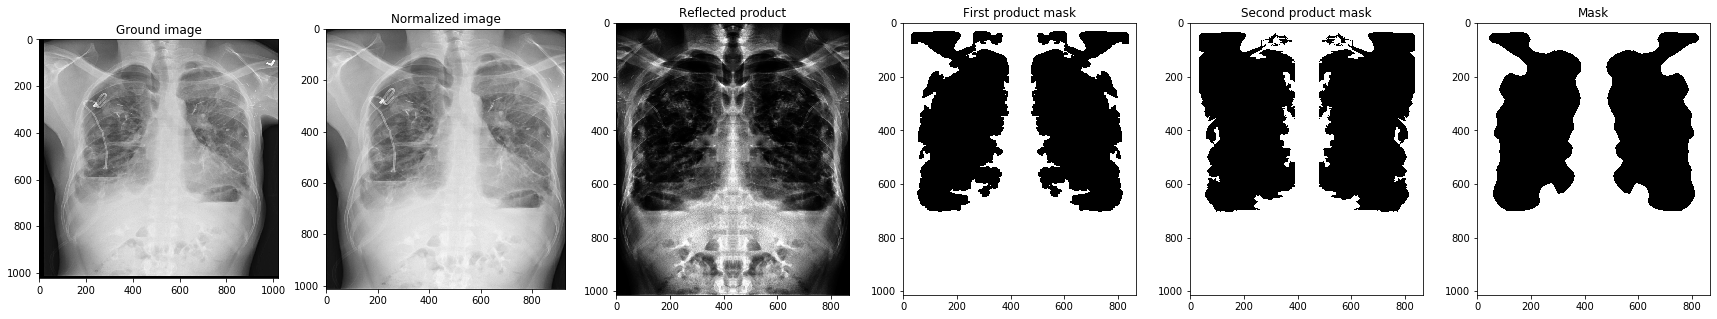

KeyboardInterrupt: 

In [16]:
for path in tqdm(glob("sample_dataset/*.jpg")):
    ground = load_image(path)
    original = blur_bbox(perspective_correction(ground))

    cleared_artefacts = remove_artefacts(original)
    x = simmetry_axis(cleared_artefacts)
    borders = get_borders(cleared_artefacts, x)
    cut_image, flipped = trim_flip(darken(cleared_artefacts, 2, (9,9)), x)
    
    reflected_product = normalize_image(cut_image.astype(float) * flipped.astype(float))
    reflected_product_mask = get_default_mask(reflected_product, borders)
    reflected_product_mask = remove_small_artefacts(reflected_product_mask, 200)
    reflected_product_mask = cv2.erode(reflected_product_mask, kernel=np.ones((3,3)), iterations=3)
    reflected_product_mask = remove_small_artefacts(reflected_product_mask, 200)
    reflected_product_mask = fill_in_small_artefacts(reflected_product_mask, 100)
    reflected_product_mask = fill_lower_max(reflected_product_mask) 
    second_product_mask = fill_in_small_artefacts(reflected_product_mask, 20)

    darkened_image = darken(cleared_artefacts, 5, (15, 15))
    darkened_image[darkened_image<np.median(darkened_image)] = 0
    darkened_image = remove_small_artefacts(darkened_image, 200)
    cut_image, flipped = trim_flip(darkened_image, x)
    cut_image = cut_image.astype(float)
    flipped = flipped.astype(float)

    second_product = normalize_image(cut_image*flipped)
    second_product_mask = get_default_mask(second_product, borders)
    second_product_mask = fill_in_small_artefacts(second_product_mask, 20)
    second_product_mask = cv2.dilate(second_product_mask, kernel=np.ones((3,3)))
    second_product_mask = fill_in_small_artefacts(second_product_mask, 20)
    second_product_mask = remove_small_artefacts(second_product_mask, 100)
    second_product_mask = fill_lower_max(second_product_mask)
    second_product_mask = fill_in_small_artefacts(second_product_mask, 20)

    composite_mask = normalize_image(reflected_product_mask.astype(float) + second_product_mask.astype(float))
    composite_mask = cv2.threshold(composite_mask, 0, 255, cv2.THRESH_BINARY)[1]
    composite_mask = cv2.medianBlur(composite_mask, 51)
    composite_mask = fill_in_small_artefacts(composite_mask, 20)
    composite_mask = remove_small_artefacts(composite_mask, 20)

    fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(30, 5))
    axes = axes.ravel()

    axes[0].set_title("Ground image")
    axes[0].imshow(ground , cmap="gray")
    
    axes[1].set_title("Normalized image")
    axes[1].imshow(original , cmap="gray")

    axes[2].set_title("Reflected product")
    axes[2].imshow(reflected_product , cmap="gray")

    axes[3].set_title("First product mask")
    axes[3].imshow(reflected_product_mask , cmap="gray")

    axes[4].set_title("Second product mask")
    axes[4].imshow(second_product_mask , cmap="gray")
    
    axes[5].set_title("Mask")
    axes[5].imshow(composite_mask, cmap="gray")
    
    plt.show()